# Variational Autoencoder

In this assignment, you will build Variational Autoencoder, train it on the MNIST dataset, and play with its architecture and hyperparameters.

### Possible display problems

If some of the formulas are not displayed correctly, you can view the file [here](https://nbviewer.jupyter.org/github/antonsavostianov/Bayes-in-ML/blob/master/VAE/vae_anton.ipynb) via nbviewer.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, InputLayer, Lambda, Concatenate 
from tensorflow.keras import Input, Model, Sequential, metrics, utils
from tensorflow.keras import backend as K

from tensorflow.keras.datasets import mnist

### Variational Autoencoder

Recall that Variational Autoencoder is a probabilistic model of data based on a continious mixture of distributions. In the lecture we covered the mixture of gaussians case, but here we will apply VAE to binary MNIST images (each pixel is either black or white). To better model binary data we will use a continuous mixture of binomial distributions: $p(x \mid w) = \int p(x \mid t, w) p(t) dt$, where the prior distribution on the latent code $t$ is standard normal $p(t) = \mathcal{N}(0, I)$, but probability that $(i, j)$-th pixel is black equals to $(i, j)$-th output of the decoder neural detwork: $p(x_{i, j} \mid t, w) = \text{decoder}(t, w)_{i, j}$.

To train this model we would like to maximize marginal log-likelihood of our dataset $\max_w \log p(X \mid w)$, but it's very hard to do computationally, so instead we maximize the Variational Lower Bound w.r.t. both the original parameters $w$ and variational distribution $q$ which we define as encoder neural network with parameters $\phi$ which takes input image $x$ and outputs parameters of the gaussian distribution $q(t \mid x, \phi)$: $\log p(X \mid w) \geq \mathcal{L}(w, \phi) \rightarrow \max_{w, \phi}$.

So overall our model looks as follows: encoder takes an image $x$, produces a distribution over latent codes $q(t \mid x)$ which should approximate the posterior distribution $p(t \mid x)$ (at least after training), samples a point from this distribution $\widehat{t} \sim q(t \mid x, \phi)$, and finally feeds it into a decoder that outputs a distribution over images.

<img src = "https://github.com/hse-aml/bayesian-methods-for-ml/blob/master/week5/VAE.png?raw=1" width = 500>

In the lecture, we also discussed that variational lower bound has an expected value inside which we are going to approximate with sampling. But it is not trivial since we need to differentiate through this approximation. However, we learned about _reparametrization trick_ which suggests instead of sampling from distribution $\widehat{t} \sim q(t \mid x, \phi)$ sample from a distribution which doesn't depend on any parameters, e.g. standard normal, and then deterministically transform this sample to the desired one: $\varepsilon \sim \mathcal{N}(0, I); ~~\widehat{t} = m(x, \phi) + \varepsilon \sigma(x, \phi)$. This way we don't have to worry about our stochastic gradient being biased and can straightforwardly differentiate our loss w.r.t. all the parameters while treating the current sample $\varepsilon$ as constant.




### Negative Variational Lower Bound

**Task 1** Derive and implement Variational Lower Bound for the continuous mixture of Binomial distributions.

**Note** that in lectures we discussed maximizing the VLB (which is typically a negative number), but in this assignment, for convenience, we will **minimize** the **negated** version of VLB (which will be a positive number) instead of maximizing the usual VLB. In what follows we always talk about _negated_ VLB, even when we use the term VLB for short.

**Also note** that to pass the test, your code should work with any mini-batch size.

To do that, we need a stochastic estimate of VLB: 
$$\text{VLB} = \sum_{i=1}^N \text{VLB}_i \approx \frac{N}{M}\sum_{i_s}^M \text{VLB}_{i_s}$$
where $N$ is the dataset size, $\text{VLB}_i$ is the term of VLB corresponding to the $i$-th object, and $M$ is the mini-batch size. But instead of this stochastic estimate of the full VLB we will use an estimate of the negated VLB normalized by the dataset size, i.e. in the function below you need to return average across the mini-batch $-\frac{1}{M}\sum_{i_s}^M \text{VLB}_{i_s}$. People usually optimize this normalized version of VLB since it doesn't depend on the dataset set - you can write VLB function once and use it for different datasets - the dataset size won't affect the learning rate too much. The correct value for this normalized negated VLB should be around $100 - 170$ in the example below.

### My calculations

#### Log incomplete likelyhood

In our case image is a 0-1 sequence. So our data take the form $X = \{x_1,\ldots, x_N\}$, $x_i\in \{0,1\}^D$.

The parameter $p=p(x|w)$, $x\in\{0,1\}^D$ is generated by decoder.

We have 

\begin{align}
& \log p (X|w) = \sum\limits_{i=1}^N \log p (x_i|w) = \sum\limits_{i=1}^N \int q_i(t)\log \frac{p(x_i|w)p(x_i,t|w)}{p(x_i,t|w)}\,dt =\\
& \sum\limits_{i=1}^N \int q_i(t)\log \frac{p(x_i,t|w)}{p(t|x_i,w)}\,dt = \sum\limits_{i=1}^N \int q_i(t)\log \frac{p(x_i,t|w)q_i(t)}{q_i(t)p(t|x_i,w)}\,dt = \\
& \sum\limits_{i=1}^N \int q_i(t)\log \frac{p(x_i,t|w)}{q_i(t)}\,dt + \sum\limits_{i=1}^N \int q_i(t)\log \frac{q_i(t)}{p(t|x_i,w)}\,dt = \\
& \sum\limits_{i=1}^N \int q_i(t)\log \frac{p(x_i,t|w)}{q_i(t)}\,dt + \mathcal{KL}( q_i(t)\,||\,p(t|x_i,w) )\geq\\
& \sum\limits_{i=1}^N \int q_i(t)\log \frac{p(x_i,t|w)}{q_i(t)}\,dt.
\end{align}

We look for $q_i(t)$ in the form $q_i(t)=q(t|x_i,\phi)=\mathcal{N}(t|m(x_i,\phi),\sigma^2(x_i,\phi))$, 
where $m(x_i,\phi)$, $\sigma(x_i,\phi)\in \mathbf{R}^d$ are produced by the encoder.

#### VLB

Below $p(t)=\mathcal{N}(t|0,I)$, $t\in\mathbf{R}^d$.

We compute

\begin{align}
& \sum\limits_{i=1}^N \int q_i(t_i)\log \frac{p(x_i,t_i|w)}{q_i(t_i)}\,dt_i = \sum\limits_{i=1}^N \int q_i(t_i)\log \frac{p(x_i|t_i,w)p(t_i)}{q_i(t_i)}\,dt_i = \\
& \sum\limits_{i=1}^N \int q_i(t_i)\log p(x_i|t_i,w)\,dt_i + 
\sum\limits_{i=1}^N \int q_i(t_i)\log \frac{p(t_i)}{q_i(t_i)}\,dt_i =\\
& \sum\limits_{i=1}^N \int q_i(t_i)\log p(x_i|t_i,w)\,dt_i - \sum_{i=1}^N\mathcal{KL}(\mathcal{N}(t_i|m(t_i,x_i),\sigma^2(t_i,x_i))\,||\, \mathcal{N}(t_i|0,I)) =\\
& \sum\limits_{i=1}^N \int q_i(t_i)\log p(x_i|t_i,w)\,dt_i - \frac{1}{2}\sum_{i = 1}^N\sum_{j=1}^D\left(\sigma^2_j(x_i,\phi) + m^2_j(x_i,\phi)-\log\sigma^2_j(x_i,\phi) - 1\right).
\end{align}

For Bernoulii model we have
\begin{equation}
p(x_i|t_i,w)=\prod\limits_{j=1}^D p(x_{ij}|t_i,w)^{[x_{ij}=1]}(1-p(x_{ij}|t_i,w))^{[x_{ij}=0]}.
\end{equation}

#### negative VLB on a batch

\begin{align}
& -VLB =  - \frac{1}{M}\sum\limits_{i=1}^M\sum_{j=1}^D\left( [x_{ij}=1]\int q_i(t_i)\log p(x_{ij}|t_i,w)\,dt_i
+ [x_{ij}=0]\int q_i(t_i)\log(1 - p(x_{ij}|t_i,w))\,dt_i\right)\\
& \qquad\qquad + \frac{1}{M}\frac{1}{2}\sum_{i = 1}^M\sum_{j=1}^D\left(\sigma^2_j(x_i,\phi) - \log\sigma^2_j(x_i,\phi) + m^2_j(x_i,\phi) - 1\right) \sim\\
&- \frac{1}{M}\sum_{i=1}^M\sum_{j=1}^D\left( [x_{ij}=1]\log p(x_{ij}|(t_i)_s,w)
+ [x_{ij}=0]\log(1 - p(x_{ij}|(t_i)_s,w))\right) +\\
& \hspace{5cm} \frac{1}{M}\frac{1}{2}\sum_{i = 1}^M\sum_{j=1}^D\left(\sigma^2_j(x_i,\phi) - \log\sigma^2_j(x_i,\phi) + m^2_j(x_i,\phi) - 1\right) = \\
& \frac{1}{M}\sum_{i=1}^M\left(-\sum_{j=1}^D\left( [x_{ij}=1]\log p(x_{ij}|(t_i)_s,w)
+ [x_{ij}=0]\log(1 - p(x_{ij}|(t_i)_s,w))\right) + \frac{1}{2}\sum_{j=1}^D\left(\sigma^2_j(x_i,\phi) - \log\sigma^2_j(x_i,\phi) + m^2_j(x_i,\phi) - 1\right)\right).
\end{align}

Here $(t_i)_s$ means a sample from the distribution $q_i(t)$.

In the code below we have

\begin{align}
x = \{x_{i,j}\}_{i,j}\quad (x\_decoded\_mean)_{ij}= p(x_{ij}|(t_i)_s,w) \quad (t\_mean)_i = m(x_i,\phi)\quad (t\_log\_var)_i = \log (\sigma^2(x_i,\phi)).
\end{align}

In [2]:
def vlb_binomial(x, x_decoded_mean, t_mean, t_log_var):
    """Returns the value of negative Variational Lower Bound
    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) matrix with one image per row with zeros and ones
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x)
    
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """
    ### MY CODE
    
    KL_i = 0.5*tf.reduce_sum(tf.math.exp(t_log_var)-t_log_var+t_mean**2-1., axis =1)
    ce_i = tf.reduce_sum(K.binary_crossentropy(x,x_decoded_mean),axis=1) 
    
    return tf.reduce_mean(ce_i+KL_i)

In [3]:
K.clear_session()

## Encoder / decoder definition

**Task 2** Read the code below that defines encoder and decoder networks and implement sampling with reparametrization trick in the provided space.

In [4]:
batch_size = 100
original_dim = 784 # Number of pixels in MNIST images.
latent_dim = 3 # d, dimensionality of the latent code t.
intermediate_dim = 256 # Size of the hidden layer.
epochs = 5

In [5]:
def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer(input_shape =(input_dim,)))
    encoder.add(Dense(intermediate_dim, activation='relu', name = "encoder_dense_1"))
    encoder.add(Dense(2 * latent_dim, name = "encoder_dense_2"))
    return encoder

get_t_mean = Lambda(lambda h: h[:, :latent_dim], name = "get_t_mean")
get_t_log_var = Lambda(lambda h: h[:, latent_dim:], name = "get_t_log_var")


# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.

class Sampling(keras.layers.Layer):
    def __init__(self):
        super(Sampling, self).__init__(name = "sampling", trainable = "False")
    def call(self, inputs):
        """
        Returns sample from a distribution N(inputs[0], diag(inputs[1]))
        The sample should be computed with reparametrization trick.
        
        The inputs are tf.Tensor
        inputs[0]: (batch_size x latent_dim) mean of the desired distribution
        inputs[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
        Returns:
            A tf.Tensor of size (batch_size x latent_dim), the samples.
        """
        t_mean, t_log_var = inputs
        eps = tf.random.normal(shape = tf.shape(t_mean), seed = 42)
        return (t_mean + eps*tf.math.exp(0.5*t_log_var))
        
def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer(input_shape = (input_dim,)))
    decoder.add(Dense(intermediate_dim, activation='relu', name = "decoder_dense_1"))
    decoder.add(Dense(original_dim, activation = "sigmoid", name = "decoder_dense_2"))
    return decoder

In [6]:
### MY CODE

class VAE(tf.keras.Model):
    def __init__(self, original_dim, latent_dim):
        super(VAE,self).__init__(name = "VAE")
        self.encoder = create_encoder(original_dim)
        self.sampling = Sampling()
        self.decoder = create_decoder(latent_dim)
    def call(self,inputs):
        h = self.encoder(inputs)
        t_mean = get_t_mean(h)
        t_log_var = get_t_log_var(h)
        t = self.sampling([t_mean,t_log_var])
        x_decoded_mean = self.decoder(t)
        loss = vlb_binomial(inputs, x_decoded_mean, t_mean, t_log_var)
        self.add_loss(loss)
        return x_decoded_mean

## Training the model

**Task 3** Run the cells below to train the model with the default settings. Modify the parameters to get better results. Especially pay attention to the encoder/decoder architectures (e.g. using more layers, maybe making them convolutional), learning rate, and the number of epochs.

In [7]:
### MY CODE

vae = VAE(original_dim,latent_dim)
vae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001))

#### Load and prepare the data

In [8]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# One hot encoding.
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#### Train the model

In [9]:
hist_vae = vae.fit(x=x_train, y=x_train, 
               shuffle = True, 
               epochs = epochs, 
               batch_size = batch_size, 
               validation_data = (x_test, x_test), 
               verbose = 1)

Epoch 1/5
600/600 [==============================] - 4s 7ms/step - loss: 180.2574 - val_loss: 159.0452
Epoch 2/5
600/600 [==============================] - 4s 7ms/step - loss: 156.7271 - val_loss: 154.5016
Epoch 3/5
600/600 [==============================] - 4s 7ms/step - loss: 152.9090 - val_loss: 151.2066
Epoch 4/5
600/600 [==============================] - 5s 8ms/step - loss: 150.3439 - val_loss: 149.8150
Epoch 5/5
600/600 [==============================] - 4s 7ms/step - loss: 148.4373 - val_loss: 147.6183


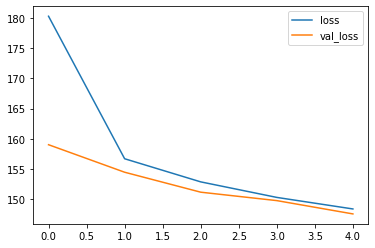

In [10]:
### MY CODE

plt.plot(hist_vae.history["loss"], label = "loss")
plt.plot(hist_vae.history["val_loss"], label = "val_loss")
plt.legend()
plt.show()

### Visualize reconstructions for train and validation data
In the picture below you can see the reconstruction ability of your network on training and validation data. In each of the two images, the left column is MNIST images and the right column is the corresponding image after passing through autoencoder (or more precisely the mean of the binomial distribution over the output images).

Note that getting the best possible reconstruction is not the point of VAE, the KL term of the objective specifically hurts the reconstruction performance. But the reconstruction should be anyway reasonable and they provide a visual debugging tool.

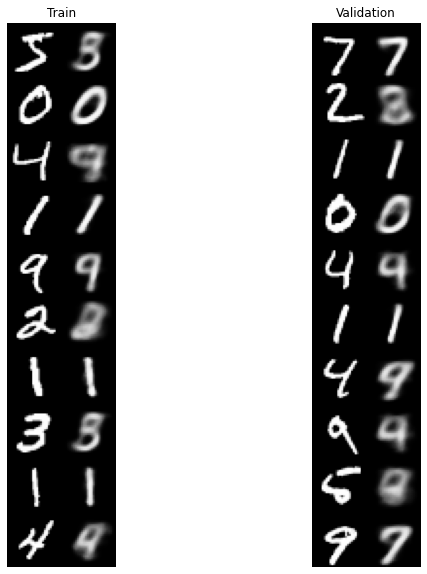

In [11]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (data, title) in enumerate(
            zip([x_train, x_test], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))

    decoded = vae(data[:batch_size, :])
    
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = data[i, :].reshape(digit_size, digit_size)
                
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = tf.reshape(decoded[i, :], shape = (digit_size, digit_size))
        
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

## Hallucinating new data
**Task 4** Write code to generate new samples of images from your trained VAE. To do that you have to sample from the prior distribution $p(t)$ and then from the likelihood $p(x \mid t)$.

**Note** that the sampling you've written in Task 2 was for the variational distribution $q(t \mid x)$, while here you need to sample from the prior.

In [12]:
n_samples = 10  # To pass automatic grading please use at least 2 samples here.

# sampled_im_mean is a tf.Tensor of size 10 x 784 with 10 random
# images sampled from the vae model.

### MY CODE

t_s = tf.random.normal(shape = (n_samples, latent_dim), seed = 42)
sampled_im_mean = vae.decoder(t_s)

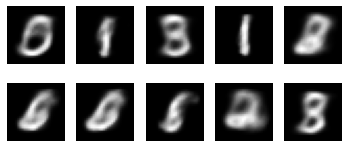

In [13]:
#sampled_im_mean_np = sess.run(sampled_im_mean)
# Show the sampled images.
plt.figure()
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1, 5, i + 1)
    plt.imshow(tf.reshape(sampled_im_mean[i, :], shape =(28, 28)), cmap='gray')
    ax.axis('off')
plt.show()

# Conditional VAE

In the final task, you will modify your code to obtain Conditional Variational Autoencoder [1]. The idea is very simple: to be able to control the samples you generate, we condition all the distributions on some additional information. In our case, this additional information will be the class label (the digit on the image, from 0 to 9).

<img src = "https://github.com/hse-aml/bayesian-methods-for-ml/blob/master/week5/CVAE.png?raw=1" width = 500>

So now both the likelihood and the variational distributions are conditioned on the class label: $p(x \mid t, \text{label}, w)$, $q(t \mid x, \text{label}, \phi)$.

The only thing you have to change in your code is to concatenate input image $x$ with (one-hot) label of this image to pass into the encoder $q$ and to concatenate latent code $t$ with the same label to pass into the decoder $p$. Note that it's slightly harder to do with convolutional encoder/decoder model.

[1] Sohn, Kihyuk, Honglak Lee, and Xinchen Yan. “Learning Structured Output Representation using Deep Conditional Generative Models.” Advances in Neural Information Processing Systems. 2015.

## Final task

**Task 5.1** Implement CVAE model. You may reuse ```create_encoder``` and ```create_decoder``` modules defined previously (now you can see why they accept the input size as an argument ;) ). You may also need `concatenate` Keras layer to concatenate labels with input data and latent code.

To finish this task, you should go to `Conditionally hallucinate data` section and find there Task 5.2

In [14]:
### MY CODE 

class CVAE(tf.keras.Model):
    def __init__(self, original_dim, latent_dim, label_dim):
        super(CVAE,self).__init__(name = "CVAE")
        self.encoder = create_encoder(original_dim + label_dim)
        self.sampling = Sampling()
        self.decoder = create_decoder(latent_dim + label_dim)
    def call(self,inputs):
        x = inputs[0]
        labels = inputs[1] 
        x_cond = Concatenate(axis = -1, name = "concatenate_encoder")([x,labels])
        h = self.encoder(x_cond)
        t_mean = get_t_mean(h)
        t_log_var = get_t_log_var(h)
        t = self.sampling([t_mean,t_log_var])
        t_cond = Concatenate(axis = -1, name = "concatenate_decoder")([t,labels])
        x_decoded_mean = self.decoder(t_cond)
        loss = vlb_binomial(x, x_decoded_mean, t_mean, t_log_var)
        self.add_loss(loss)
        return x_decoded_mean

In [15]:
label_dim = 10

## Define the loss and the model

In [16]:
### MY CODE

cvae = CVAE(original_dim, latent_dim, label_dim)
cvae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001))

### Train the model

In [17]:
hist_cvae = cvae.fit(x=[x_train, y_train],
                y=x_train,
                shuffle=True,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=([x_test, y_test], x_test),
                verbose=1)

Epoch 1/5
600/600 [==============================] - 5s 8ms/step - loss: 169.2915 - val_loss: 143.8066
Epoch 2/5
600/600 [==============================] - 4s 7ms/step - loss: 140.3861 - val_loss: 136.4203
Epoch 3/5
600/600 [==============================] - 4s 7ms/step - loss: 135.6032 - val_loss: 133.5838
Epoch 4/5
600/600 [==============================] - 4s 7ms/step - loss: 133.1345 - val_loss: 131.3877
Epoch 5/5
600/600 [==============================] - 4s 7ms/step - loss: 131.4569 - val_loss: 130.3859


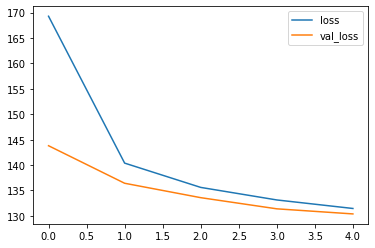

In [18]:
### MY CODE

plt.plot(hist_cvae.history["loss"], label = "loss")
plt.plot(hist_cvae.history["val_loss"], label = "val_loss")
plt.legend()
plt.show()

### Visualize reconstructions for train and validation data

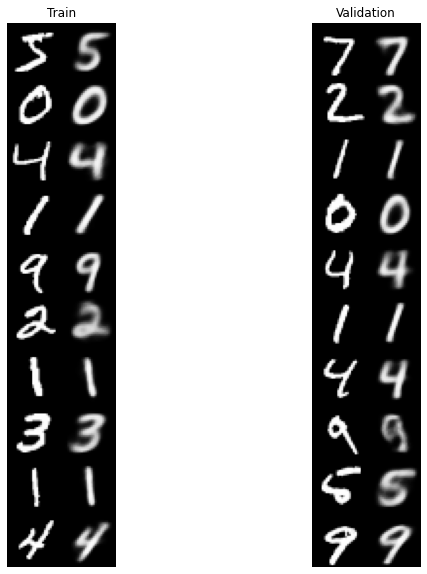

In [19]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (x_data, y_data, title) in enumerate(
            zip([x_train, x_test], [y_train, y_test], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
        
    decoded = cvae([x_data[:batch_size, :],y_data[:batch_size, :]])
    
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = x_data[i, :].reshape(digit_size, digit_size)
        
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = tf.reshape(decoded[i, :], shape = (digit_size, digit_size))
        
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

## Conditionally hallucinate data
**Task 5.2** Implement the conditional sampling from the distribution $p(x \mid t, \text{label})$ by firstly sampling from the prior $p(t)$ and then sampling from the likelihood $p(x \mid t, \text{label})$.

In [20]:
# Prepare one hot labels of form
#   0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 ...
# to sample five zeros, five ones, etc
curr_labels = np.eye(10, dtype = "float32")
curr_labels = np.repeat(curr_labels, 5, axis=0)  # Its shape is 50 x 10.

### MY CODE

n_samples = curr_labels.shape[0]
t = tf.random.normal(shape=(n_samples,latent_dim))
cond_t = Concatenate(axis = -1, name = "concatenate_hallu")([t,curr_labels])

# cond_sampled_im_mean is a tf.Tensor of size 50 x 784 with 5 random zeros,
# then 5 random ones, etc sampled from the cvae model.
cond_sampled_im_mean = cvae.decoder(cond_t)

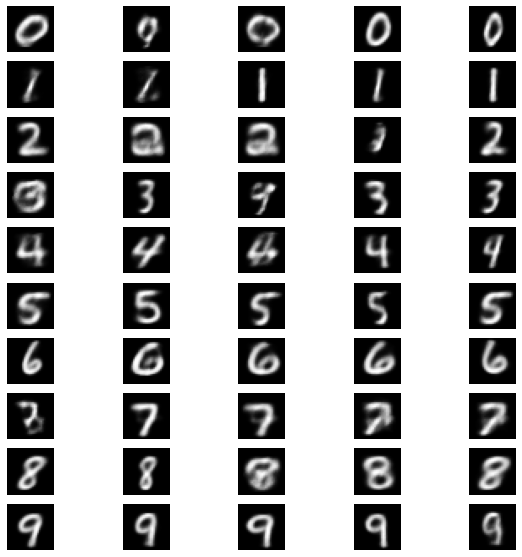

In [21]:
#cond_sampled_im_mean_np = sess.run(cond_sampled_im_mean)
# Show the sampled images.
plt.figure(figsize=(10, 10))
global_idx = 0
for digit in range(10):
    for _ in range(5):
        ax = plt.subplot(10, 5, global_idx + 1)
        plt.imshow(tf.reshape(cond_sampled_im_mean[global_idx, :], shape = (28, 28)), 
                   cmap='gray')
        ax.axis('off')
        global_idx += 1
plt.show()